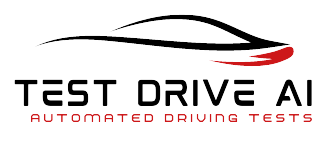

# DubHacks 2024
##### Sam Chou, Josh Chou, Issac Dyor, Brian Dinh

#### Mission
Test Drive AI aims to make roads safer by addressing the variability and inconsistency present in traditional driving tests.
- Resource Intensive
- Subjective Evaluation
- Time Consuming
- Safety Concerns

# Approach
An all-in-one software platform for automated, standardized driving tests.​

# Functionalities Of Our Software:

### Lane detection
- Grayscale conversion to improve canny edge detection​
- Canny Edge Detection
- Hough Line transform for minLineLength and minLineGap

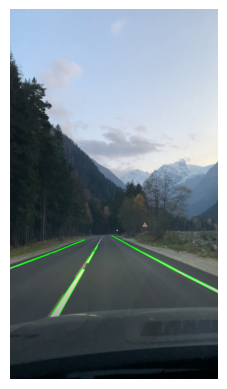

In [1]:
import cv2
from ultralytics import YOLO
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os
import sys
import dlib
from scipy.spatial import distance as dist
from collections import deque
import time
import torch

# Helper function to check if two line segments (p1-p2) and (q1-q2) intersect
def line_intersects(p1, p2, q1, q2):
    def orientation(a, b, c):
        val = (b[1] - a[1]) * (c[0] - b[0]) - (b[0] - a[0]) * (c[1] - b[1])
        if val == 0:
            return 0  # Collinear
        return 1 if val > 0 else 2  # Clockwise or counterclockwise

    def on_segment(a, b, c):
        return min(a[0], c[0]) <= b[0] <= max(a[0], c[0]) and min(a[1], c[1]) <= b[1] <= max(a[1], c[1])

    o1 = orientation(p1, p2, q1)
    o2 = orientation(p1, p2, q2)
    o3 = orientation(q1, q2, p1)
    o4 = orientation(q1, q2, p2)

    # General case
    if o1 != o2 and o3 != o4:
        return True

    # Special cases
    if o1 == 0 and on_segment(p1, q1, p2):
        return True
    if o2 == 0 and on_segment(p1, q2, p2):
        return True
    if o3 == 0 and on_segment(q1, p1, q2):
        return True
    if o4 == 0 and on_segment(q1, p2, q2):
        return True

    return False

# Function to detect lanes and determine if car is crossing the lane
def detect_lanes(frame):
    height, width, _ = frame.shape
    center_x = width // 2  # Car's assumed position (center of the frame)

    # Define x offset to shift the triangle horizontally
    x_offset = -40  # Positive value shifts to the right, negative shifts to the left

    # Adjust these values to define the size and position of the "red zone"
    lane_crossing_threshold = 250  # Horizontal base of the triangle
    vertical_proximity_threshold = 150  # Height of the triangle
    move_down_offset = 600  # Move the triangle down by this amount

    bottom_threshold = int(2 * height // 3) + move_down_offset  # Move the triangle down slightly

    # Define the points for the triangular red zone (isosceles triangle) with x_offset
    triangle_points = np.array([
        [center_x - lane_crossing_threshold + x_offset, bottom_threshold],  # Left corner of the base
        [center_x + lane_crossing_threshold + x_offset, bottom_threshold],  # Right corner of the base
        [center_x + x_offset * 4.5, bottom_threshold - vertical_proximity_threshold]  # Top point (apex)
    ]).astype(np.float32)  # Convert to float for pointPolygonTest compatibility

    # Draw the "red zone" triangle in purple
    #cv2.polylines(frame, [triangle_points.astype(np.int32)], isClosed=True, color=(128, 0, 128), thickness=3)

    # Define triangle sides as line segments
    tri_p1, tri_p2, tri_p3 = triangle_points
    triangle_sides = [(tri_p1, tri_p2), (tri_p2, tri_p3), (tri_p3, tri_p1)]

    # Cropping the frame to remove unwanted areas
    crop_y_start = int(height // 2)  # Cropping out the top half
    crop_y_end = height  # Keep the bottom half of the frame
    cropped_frame = frame[crop_y_start:crop_y_end, :]  # Crop vertically, keeping full width

    # Convert the cropped frame to grayscale
    gray = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(gray, 150, 300)

    # Detect lines using Hough transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=20)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]

            # Adjust y-coordinates because we cropped part of the frame
            y1 += crop_y_start
            y2 += crop_y_start

            # Convert points to float for intersection testing
            point1 = (float(x1), float(y1))
            point2 = (float(x2), float(y2))

            # Check if the line intersects with any of the triangle's sides
            intersects_triangle = any(line_intersects(point1, point2, *side) for side in triangle_sides)

            # If the line intersects the triangle, color it red
            if intersects_triangle:
                cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 5)  # Red line
            else:
                cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 5)  # Green line

    return frame

# Load video
cap = cv2.VideoCapture('lane-detection.mp4')

# Process and display video frames using matplotlib
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect lanes
    lanes_frame = detect_lanes(frame)

    # Convert BGR to RGB for Matplotlib
    rgb_frame = cv2.cvtColor(lanes_frame, cv2.COLOR_BGR2RGB)

    # Clear the previous plot
    clear_output(wait=True)

    # Display the result using Matplotlib
    plt.imshow(rgb_frame)
    plt.axis('off')  # Hide axis
    plt.show()

cap.release()

### Driver Awareness detection
- Dlib’s 68-point facial landmark model to track key facial features, focusing on the eyes
- Evaluates whether the driver is looking straight ahead, left, or right by comparing the amount of white space in the eye.
- YoloV5 model Phone Detection
- Red indicates distraction which factors into scoring​

### Tailgating /Crash detection 
- Ensure that the driver is keeping a safe distance from the car in front
- Identify the center of the car and establish the “Red Zone”

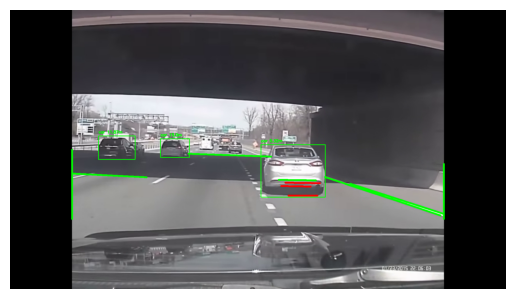

In [2]:
# Load the YOLOv8 model
model = YOLO('yolov8n.pt')

# Open the video file
cap = cv2.VideoCapture('Clipped_Break.mp4')

def line_intersects(p1, p2, q1, q2):
    def orientation(a, b, c):
        val = (b[1] - a[1]) * (c[0] - b[0]) - (b[0] - a[0]) * (c[1] - b[1])
        if val == 0:
            return 0  # Collinear
        elif val > 0:
            return 1  # Clockwise
        else:
            return 2  # Counterclockwise

    def on_segment(a, b, c):
        if min(a[0], c[0]) <= b[0] <= max(a[0], c[0]) and min(a[1], c[1]) <= b[1] <= max(a[1], c[1]):
            return True
        return False

    o1 = orientation(p1, p2, q1)
    o2 = orientation(p1, p2, q2)
    o3 = orientation(q1, q2, p1)
    o4 = orientation(q1, q2, p2)

    if o1 != o2 and o3 != o4:
        return True

    if o1 == 0 and on_segment(p1, q1, p2):
        return True
    if o2 == 0 and on_segment(p1, q2, p2):
        return True
    if o3 == 0 and on_segment(q1, p1, q2):
        return True
    if o4 == 0 and on_segment(q1, p2, q2):
        return True

    return False

def detect_lanes(frame):
    height, width, _ = frame.shape
    center_x = width // 2

    x_offset = 120

    lane_crossing_threshold = 200
    vertical_proximity_threshold = 150
    move_down_offset = 90

    bottom_threshold = int(2 * height // 3) + move_down_offset

    triangle_points = np.array([
        [center_x - lane_crossing_threshold + x_offset, bottom_threshold],
        [center_x + lane_crossing_threshold + x_offset, bottom_threshold],
        [center_x + x_offset, bottom_threshold - vertical_proximity_threshold]
    ]).astype(np.float32)

    tri_p1, tri_p2, tri_p3 = triangle_points
    triangle_sides = [(tri_p1, tri_p2), (tri_p2, tri_p3), (tri_p3, tri_p1)]

    crop_y_start = int(height // 2)
    crop_y_end = int(0.75 * height)
    cropped_frame = frame[crop_y_start:crop_y_end, :]

    gray = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 150, 350)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=20)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]

            y1 += crop_y_start
            y2 += crop_y_start

            point1 = (float(x1), float(y1))
            point2 = (float(x2), float(y2))

            intersects_triangle = any(line_intersects(point1, point2, *side) for side in triangle_sides)

            if intersects_triangle:
                cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 5)
            else:
                cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 5)

    return frame

def display_frame(frame):
    clear_output(wait=True)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()

def estimate_distance(box_height, frame_height, scale_factor):
    distance = (frame_height / (box_height + 1e-5)) * scale_factor
    return round(distance, 2)

def is_in_trapezoid(box, trapezoid_pts):
    x1, y1, x2, y2 = box
    step_size = 5
    for x in range(x1, x2, step_size):
        for y in range(y1, y2, step_size):
            if cv2.pointPolygonTest(np.array(trapezoid_pts, np.int32), (float(x), float(y)), False) >= 0:
                return True
    return False

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    lanes_frame = detect_lanes(frame)

    results = model(frame)

    height, width, _ = frame.shape

    trapezoid_top_left = (int(0.4 * width), int(0.85 * height))
    trapezoid_top_right = (int(0.6 * width), int(0.85 * height))
    trapezoid_bottom_left = (int(0.45 * width), int(0.7 * height))
    trapezoid_bottom_right = (int(0.55 * width), int(0.7 * height))
    trapezoid_pts_outer = [trapezoid_top_left, trapezoid_top_right, trapezoid_bottom_right, trapezoid_bottom_left]

    inner_trapezoid_top_left = (int(0.42 * width), int(0.85 * height))
    inner_trapezoid_top_right = (int(0.58 * width), int(0.85 * height))
    inner_trapezoid_bottom_left = (int(0.47 * width), int(0.79 * height))
    inner_trapezoid_bottom_right = (int(0.53 * width), int(0.79 * height))
    trapezoid_pts_inner = [inner_trapezoid_top_left, inner_trapezoid_top_right, inner_trapezoid_bottom_right, inner_trapezoid_bottom_left]

    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()
        classes = result.boxes.cls.cpu().numpy()
        for i in range(len(boxes)):
            cls = int(classes[i])
            if cls in [2, 5, 7]:
                x1, y1, x2, y2 = boxes[i].astype(int)
                box_height = y2 - y1

                if y2 > int(0.95 * height):
                    continue

                scale_factor = {2: 1.0, 5: 2.5, 7: 1.7}.get(cls, 1.0)
                distance = estimate_distance(box_height, height, scale_factor)

                if is_in_trapezoid((x1, y1, x2, y2), trapezoid_pts_inner):
                    color = (0, 0, 255)
                elif is_in_trapezoid((x1, y1, x2, y2), trapezoid_pts_outer):
                    color = (0, 255, 255)
                else:
                    color = (0, 255, 0)

                cv2.rectangle(lanes_frame, (x1, y1), (x2, y2), color, 2)
                label = f"{model.names[cls]} {distance}m"
                cv2.putText(lanes_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    display_frame(lanes_frame)

cap.release()
plt.close()

# Business Analysis
- Test Drive AI is a SaaS platform that automates and standardizes driving tests
- Analyzing dashcam and driver footage using AI, providing consistent and unbiased evaluations for driving schools.
- Scalable infrastructure to handle increasing customer demand

# Looking Ahead
### More detection abilities​
- Check for headlights at night
- Ensure user is checking mirrors
- Check for hard-braking​
### Integrate other sensors/checks (speedometer, turn signals…)​
- Integrate a voice component that can provide live feedback/audio cues as a real instructor would​
- Add driving education to our platform​
### Tutorials on website, voice walkthroughs…
- Gather dashcam footage from driving schools and respective driving reports to improve our model​